# Feature Importance

## Imports and Useful Paths

In [1]:
# Helper libraries
import warnings

# Scientific and visual libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Various settings
warnings.filterwarnings("ignore")
np.set_printoptions(precision=4)
sns.set_theme()
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_colwidth", 40)
pd.set_option("display.precision", 4)
pd.set_option("display.max_columns", None)

## Loading Train Set

In [2]:
from churn_detection.paths import TRANSFORMED_DATA_DIR

In [3]:
train_df = pd.read_feather(TRANSFORMED_DATA_DIR / "train.feather")

In [4]:
numeric_variables = [
    "tenure", 
    "monthlycharges", 
    "totalcharges"
]

categorical_variables = [
    var for var in train_df.columns
    if var not in numeric_variables
    and var != "churn"
]

## Correlation Analysis

### Numerical Features with Target

<Axes: >

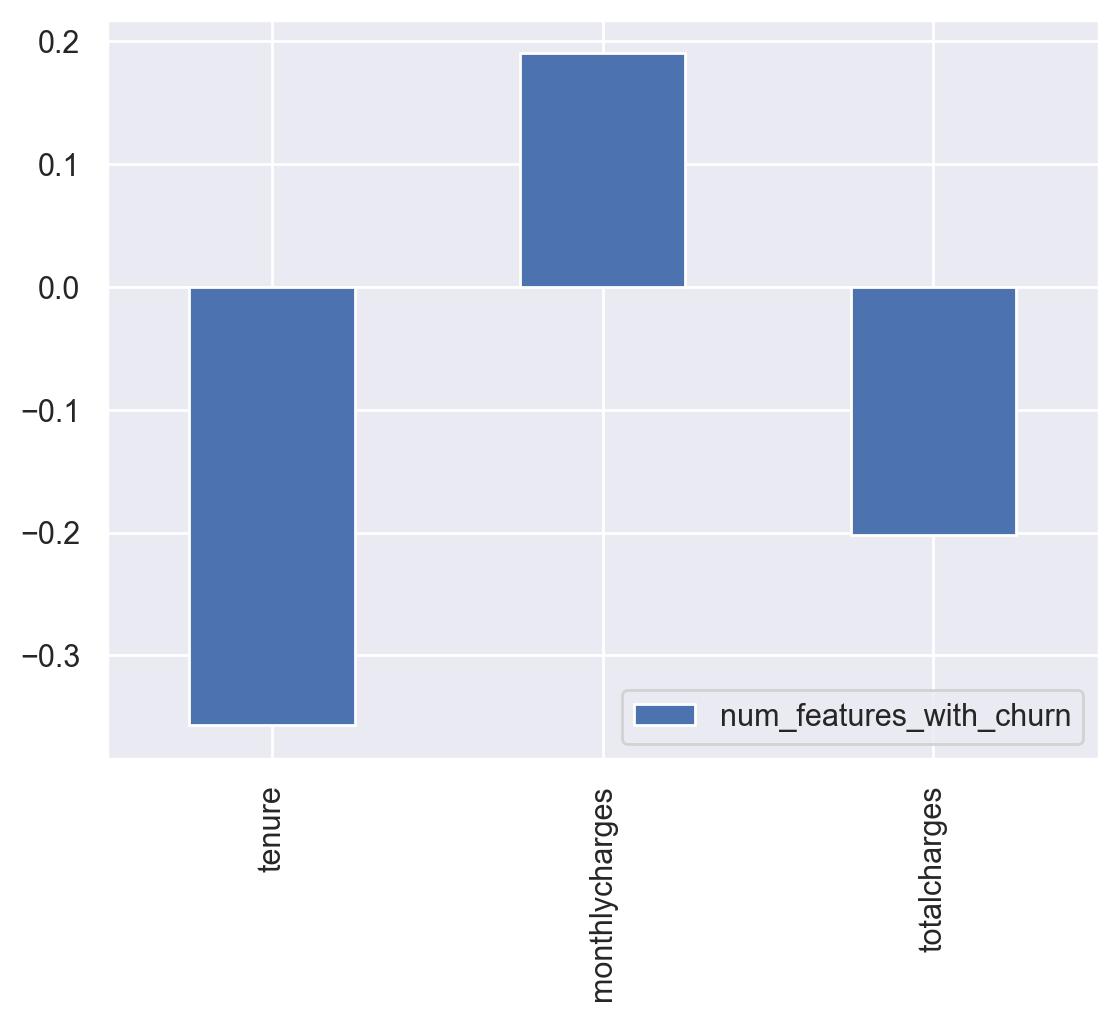

In [5]:
(train_df[numeric_variables]
 .corrwith(train_df.churn)
 .to_frame(name="num_features_with_churn")
 .plot
 .bar()
)

Churn risk increases when the following features decrease:
- tenure
- totalcharges

Churn risk increases when the following feature increases:
- monthlycharges

Tenure seems the most important numeric feature for predicting churn in the sense that the longer customers stay, the less often they tend to churn. The same effect can be assumed with the variable totalcharges given that there is a strong natural correlation between them, making totalcharges a near-proxy of tenure. <br><br>
For monthlycharges, customers with higher charges may find the service expensive compared to the perceived value they receive. This is obvious if the users have limited budgets or competing options that offer lower costs. But we don't have indicators of perceived value, nor any customer budget history, so it's difficult to be definitive. We often think that customers who pay more may have a lower tolerance for errors, outages or substandard customer support, but we've seen the opposite happen: irrational zero tolerance when the cheap thing ultimately doesn't work as expected.

### Categorical Features with Target

In [6]:
from churn_detection.visualization import plot_cramer

In [7]:
discrete_vars = categorical_variables+["churn"]
train_viz = train_df.copy()
train_viz[discrete_vars] = train_viz[discrete_vars].astype('category')

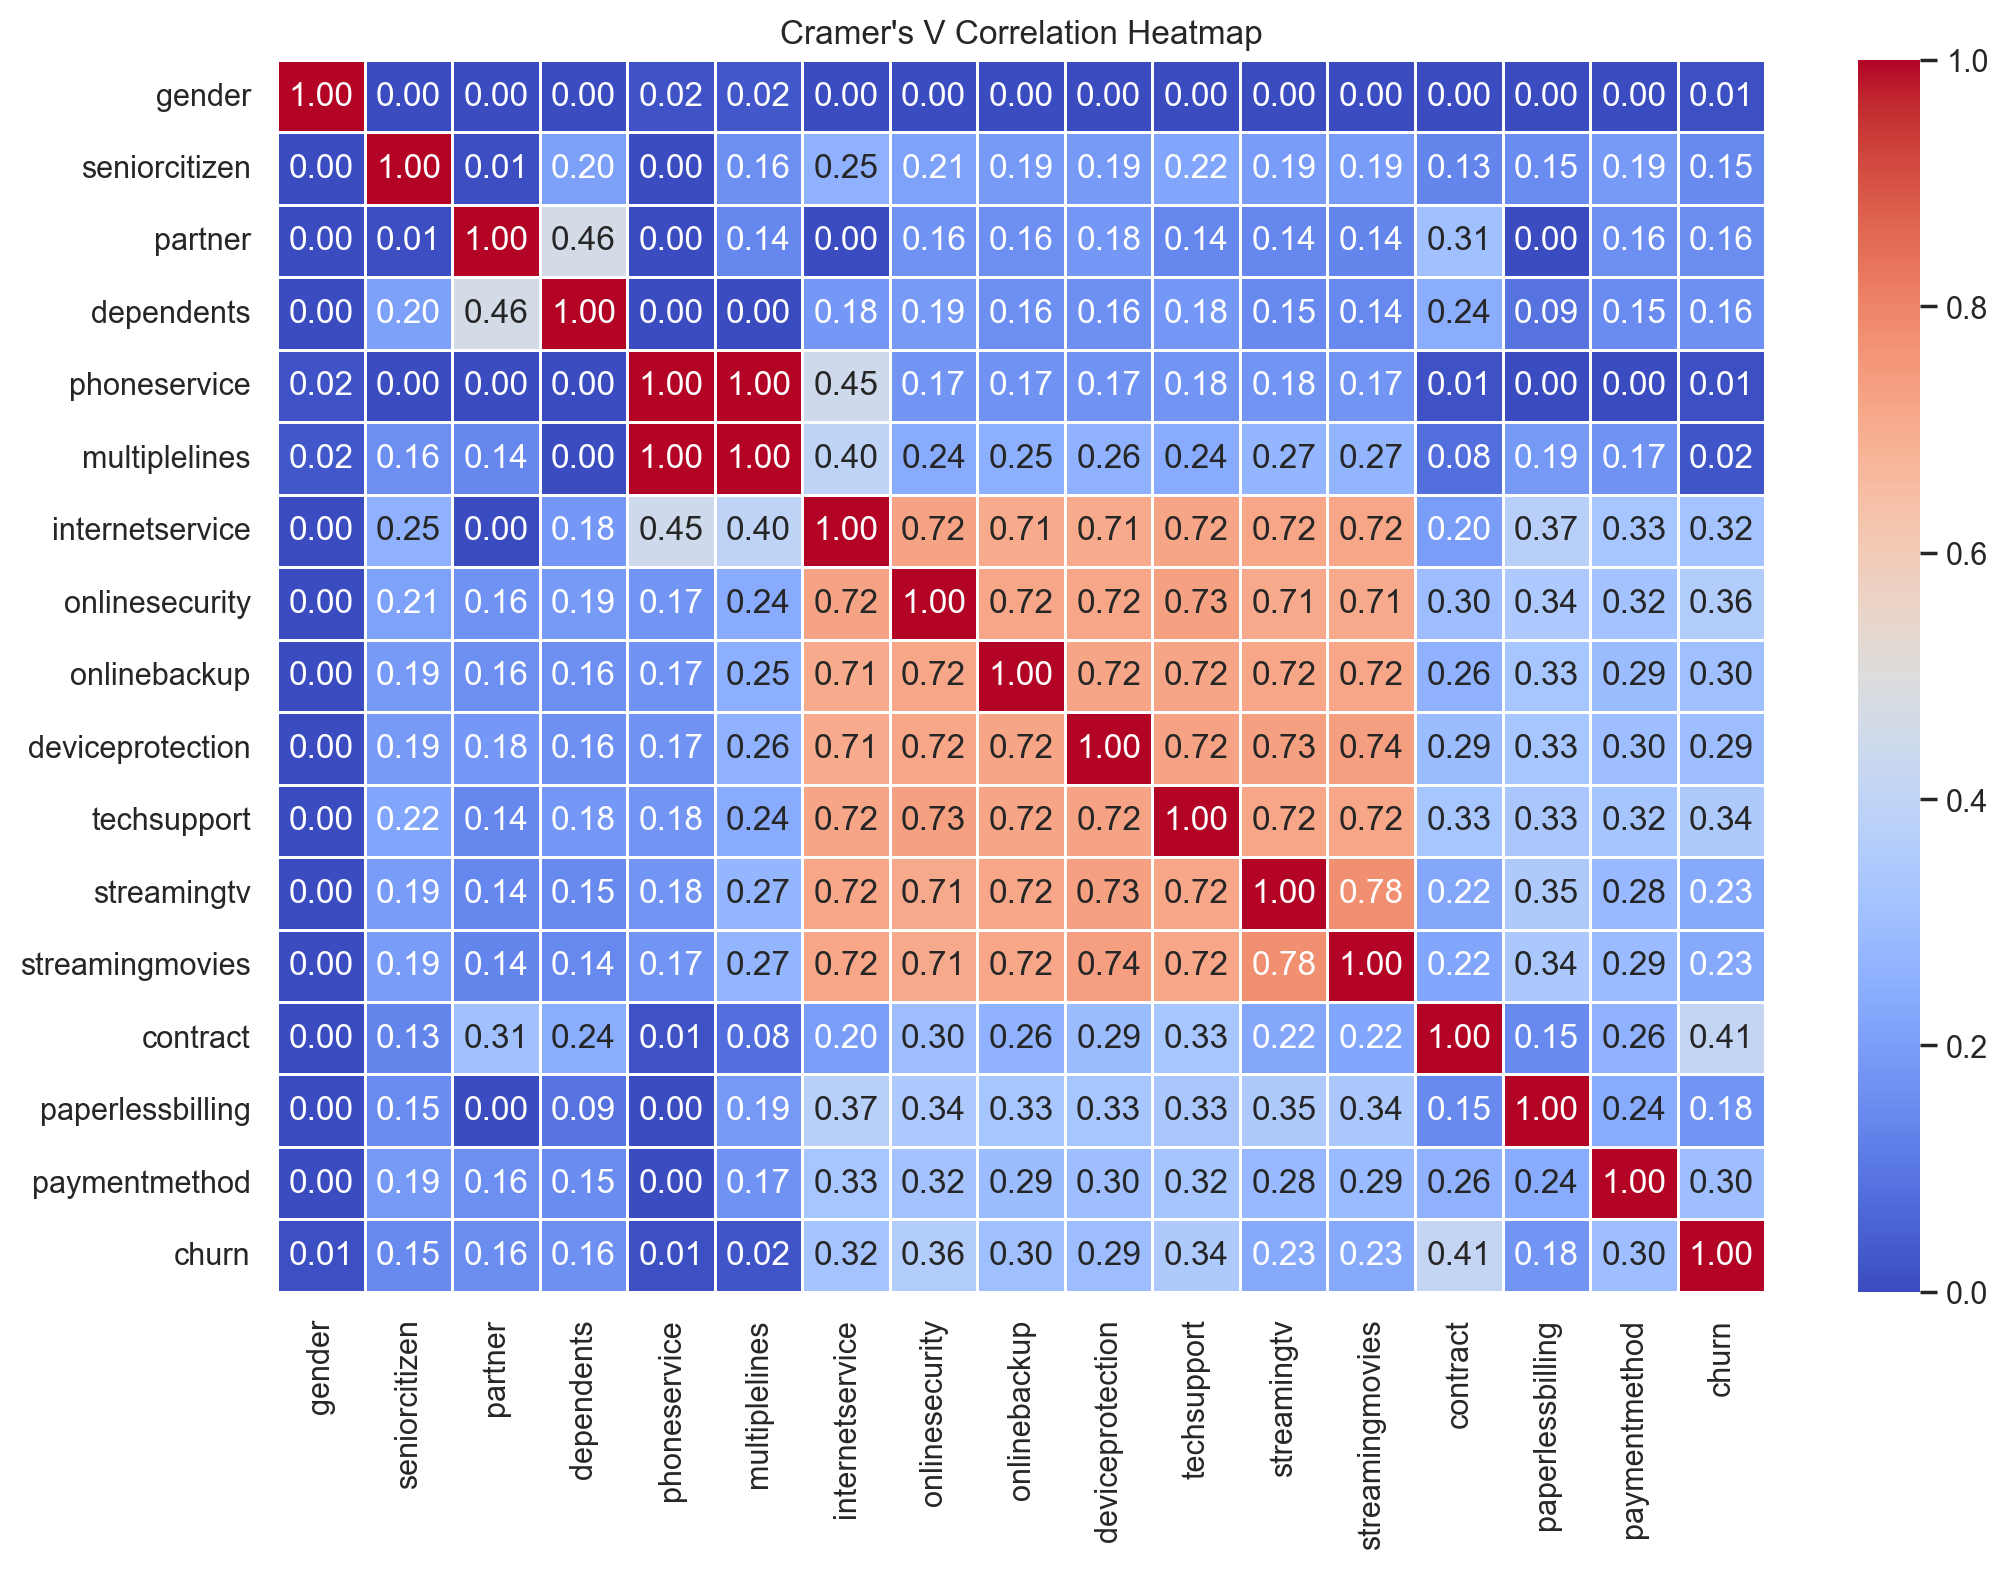

In [8]:
plot_cramer(train_viz[discrete_vars], size=(12, 8))

A strong correlation between contract and churn. We can inspect the churn rate for each category in contract.

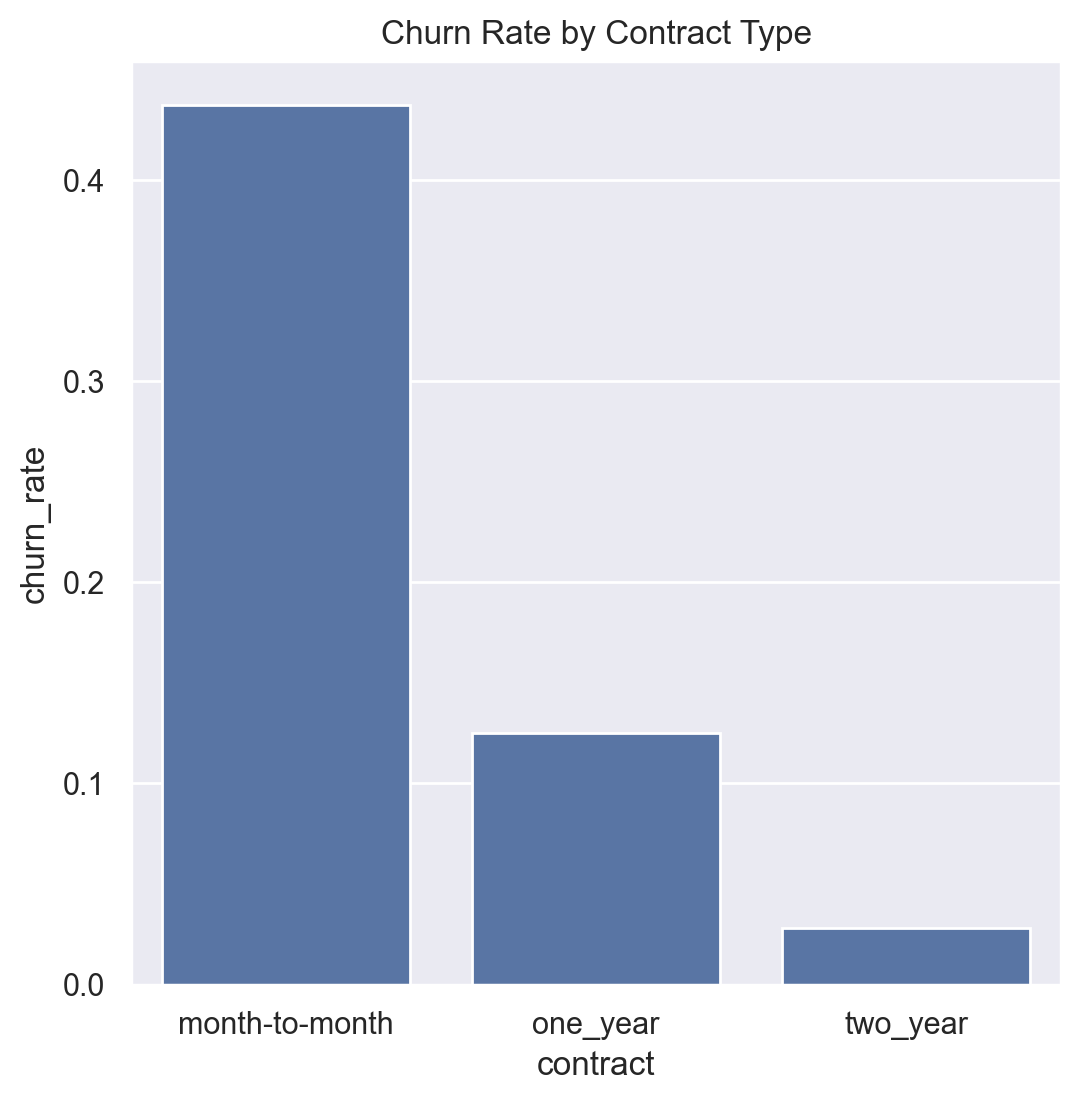

In [9]:
contract_churn = (
    train_df
    .groupby("contract")["churn"]
    .mean()
    .reset_index()
    .rename(columns={"churn": "churn_rate"})
    .sort_values(by="churn_rate", ascending=False)
)

plt.figure(figsize=(6, 6))
sns.barplot(x=contract_churn["contract"], y=contract_churn["churn_rate"])
plt.title("Churn Rate by Contract Type")
plt.show()

Monthly contracts are more risky. On these flexible contracts users can leave anytime, making them more likely to churn compared to those with longer commitments.

Contract type is followed by the group of service-based features. We know that customers who have one service are very likely to have the other. The correlation between these features and target churn variable is moderate, indicating some degree of overlap. For instance onlinesecurity and techsupport: customers subscribing to online security often also opt for tech support probably as part of a complete service package.

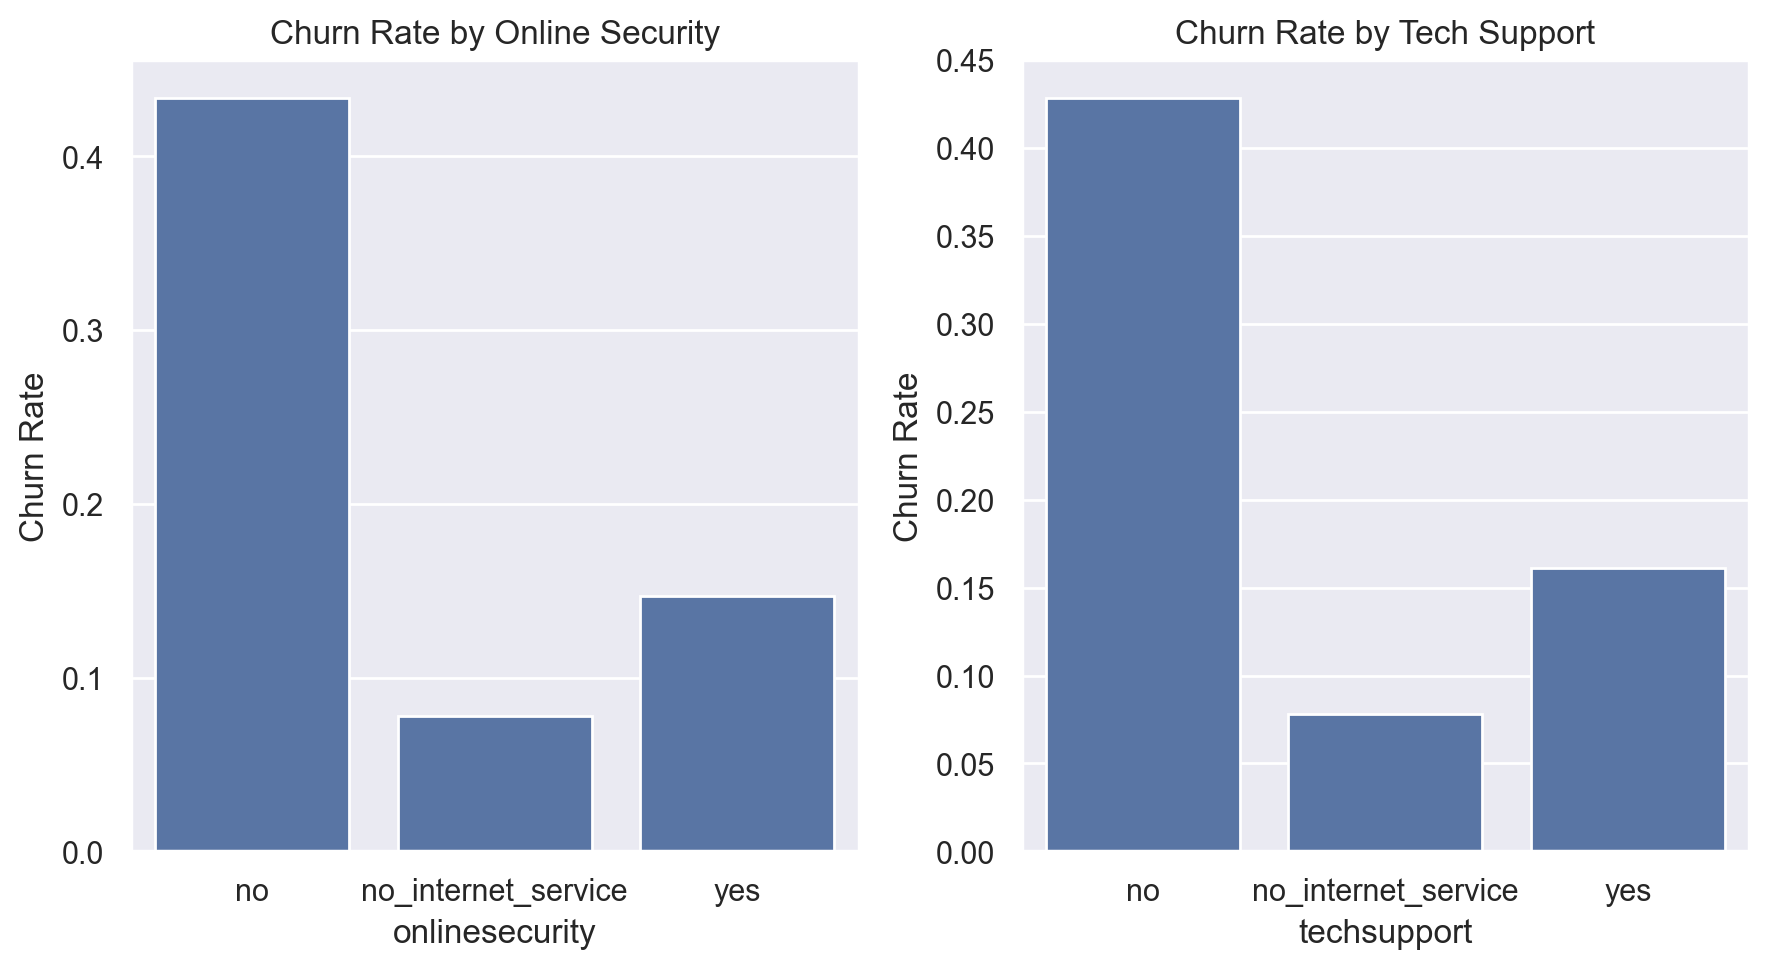

In [10]:
onlinesecurity_churn = (
    train_df
    .groupby("onlinesecurity")["churn"]
    .mean()
    .reset_index()
    .rename(columns={"churn": "churn_rate"})
)

techsupport_churn = (
    train_df
    .groupby("techsupport")["churn"]
    .mean()
    .reset_index()
    .rename(columns={"churn": "churn_rate"})
)


plt.figure(figsize=(9, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=onlinesecurity_churn["onlinesecurity"], y=onlinesecurity_churn["churn_rate"])
plt.ylabel("Churn Rate")
plt.title("Churn Rate by Online Security")

plt.subplot(1, 2, 2)
sns.barplot(x=techsupport_churn["techsupport"], y=techsupport_churn["churn_rate"])
plt.ylabel("Churn Rate")
plt.title("Churn Rate by Tech Support")

plt.tight_layout()
plt.show()

The higher churn risk among customers without these services (they have same distribution) suggest a pattern of dissatisfaction or low perceived value.

Another interesting variable is paymentmethod. 

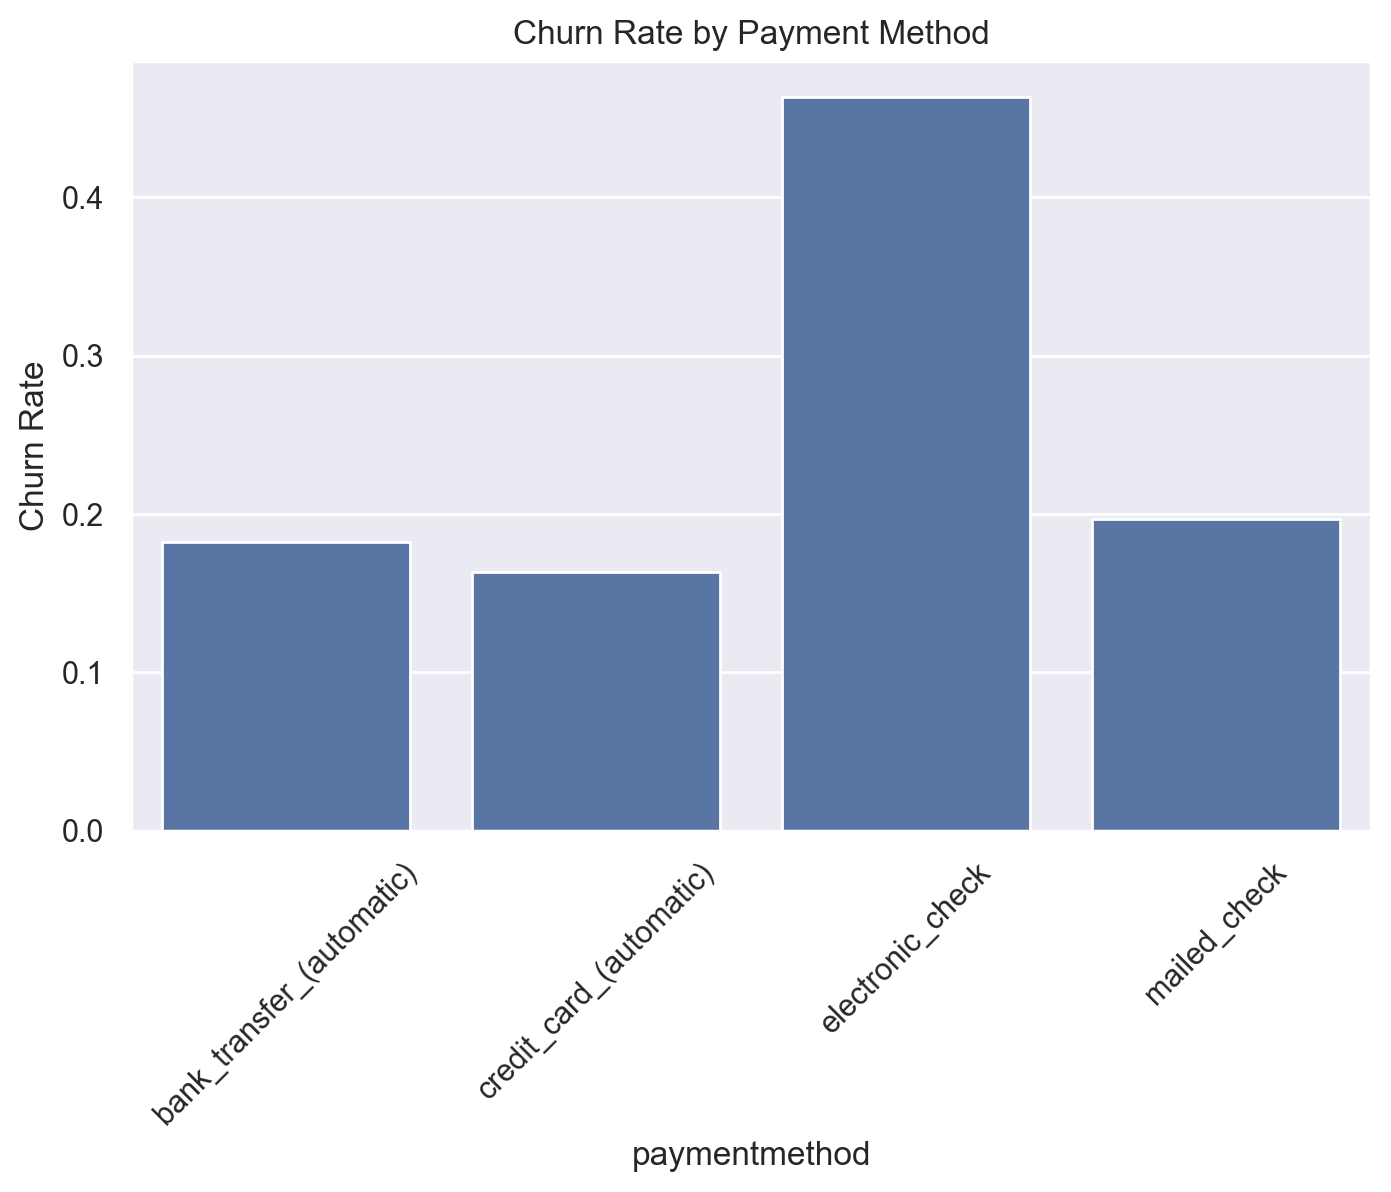

In [11]:
paymentmethod_churn = (
    train_df
    .groupby("paymentmethod")["churn"]
    .mean()
    .reset_index()
    .rename(columns={"churn": "churn_rate"})
)

plt.figure(figsize=(8, 5))
sns.barplot(x=paymentmethod_churn["paymentmethod"], y=paymentmethod_churn["churn_rate"])
plt.ylabel("Churn Rate")
plt.title("Churn Rate by Payment Method")
plt.xticks(rotation=45)
plt.show()

Customers using electronic_check method may have more dissatisfaction. It's probably due to manual processes, and the errors that result from them.

## Mutual Information

In [12]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import mutual_info_score

### Continuous Features for Classification

In [13]:
names = numeric_variables

In [14]:
mi_scores = mutual_info_classif(train_df[numeric_variables], train_df.churn)

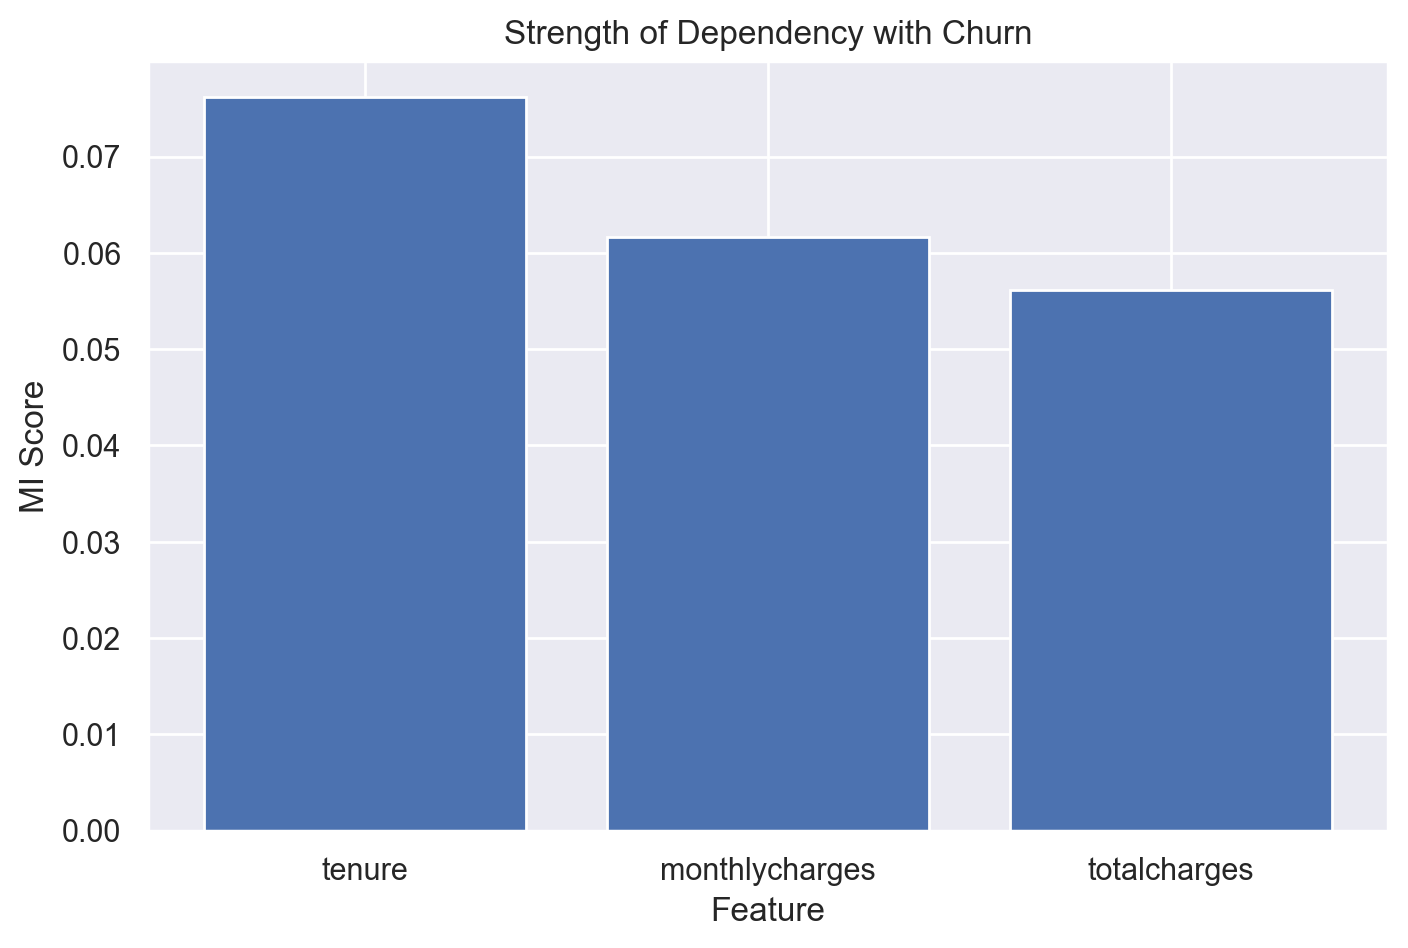

In [15]:
plt.figure(figsize=(8, 5))
plt.bar(names, mi_scores)
plt.xlabel("Feature")
plt.ylabel("MI Score")
plt.title("Strength of Dependency with Churn")
plt.show()

Result is similar to that of correlation analysis, except that we do not have the direction of the dependency.

### Discrete Features for Classification

In [16]:
df_mi = (
    train_df[categorical_variables]
    .apply(lambda x: mutual_info_score(x, train_df.churn))
    .sort_values(ascending=False)
    .to_frame(name='CAT_MI')
)
df_mi

,CAT_MI
contract,0.0998
onlinesecurity,0.0686
techsupport,0.0637
internetservice,0.0551
onlinebackup,0.0495
deviceprotection,0.0472
paymentmethod,0.0430
streamingtv,0.0323
streamingmovies,0.0322
paperlessbilling,0.0162


As we see, contract, online security, and tech support are are quite informative, and result is similar to Crammer's V coefficients. It’s also not surprising that gender and phoneservice are the least important features.

## Churn Rate Analysis

Previously in Target Analysis, we have calculated the global churn rate in train and validation sets, that is the probability of churn corresponding to the proportion of all customers declared to stop using the telco service.

So 27.4% is the global churn rate in train data. By splitting each variable into several groups, we can inspect  this metric in each group and compare it with the train churn rate. This process is as follows:
- identifying how groups within each feature deviate from the global churn rate
- identifying patterns indicative of significant predictive power.

### Group Rate Vs. Population Rate

In [17]:
train_rate = train_df.churn.mean()

In [18]:
# Contract Type
monthly_rate = train_df[train_df.contract=="month-to-month"].churn.mean().round(3)
one_year_rate = train_df[train_df.contract=="one_year"].churn.mean().round(3)
two_year_rate = train_df[train_df.contract=="two_year"].churn.mean().round(3)

In [19]:
contract_rates = monthly_rate, one_year_rate, two_year_rate

In [20]:
pd.Series(contract_rates).describe()

count    3.0000
mean     0.1970
std      0.2143
min      0.0280
25%      0.0765
50%      0.1250
75%      0.2815
max      0.4380
dtype: float64

In [21]:
(contract_rates > train_rate).mean()

np.float64(0.3333333333333333)

The difference between group rates for this variable indicates that knowing the type of contract help us to identify whether they will be in high churn risk. 
One third of the group rates are significantly above the global train rate (we know that max = 43.8% and that their variance is higher than mean).

We should get the same result for high-important variables we identified previously. One thing we can do is to perform churn rate analysis with variables supposed to be of low importance.

In [22]:
# Phone Service
yes_phone_rate = train_df[train_df.phoneservice=="yes"].churn.mean().round(3)
no_phone_rate = train_df[train_df.phoneservice=="no"].churn.mean().round(3)

In [23]:
phone_rates = yes_phone_rate, no_phone_rate

In [24]:
pd.Series(phone_rates).describe()

count    2.0000
mean     0.2625
std      0.0205
min      0.2480
25%      0.2552
50%      0.2625
75%      0.2698
max      0.2770
dtype: float64

In [25]:
(phone_rates > train_rate).mean()

np.float64(0.5)

In [26]:
phone_rates

(np.float64(0.277), np.float64(0.248))

The difference between group rates for this feature indicates that knowing the phoneservice group of the customer may help us to identify whether they will be churn risky. 
Mutual information have shown us the low importance of this feature but group rates show that:
- one group (yes_phoneservice) has a greater rate than global train rate
- another (no_phoneservice) has a lesser rate than train rate.

Conclusion: it can be useful to keep information from this variable instead of removing it. After all, customers with complete service bundles (phone + internet + TV) may have dissatisfaction if one component fails or does not meet expectations.

Another interest low importance feature is paperlessbilling:

In [27]:
yes_paperlessbilling_rate = train_df[train_df.paperlessbilling=="yes"].churn.mean().round(3)
no_paperlessbilling_rate = train_df[train_df.paperlessbilling=="no"].churn.mean().round(3)

In [28]:
paperlessbilling_rates = yes_paperlessbilling_rate, no_paperlessbilling_rate

In [29]:
pd.Series(paperlessbilling_rates).describe()

count    2.0000
mean     0.2585
std      0.1138
min      0.1780
25%      0.2182
50%      0.2585
75%      0.2988
max      0.3390
dtype: float64

In [30]:
(paperlessbilling_rates > train_rate).mean()

np.float64(0.5)

In [31]:
paperlessbilling_rates

(np.float64(0.339), np.float64(0.178))

Same conclusion: one group has higher churn rate than global train rate, the other no. Customers opting for paperless billing are often younger, tech-savvy, and better informed about competitors, which leads to more willing to switch providers for better deals. And it is moderately correlated with payment method.

Let's do it for all discrete variables.

In [32]:
def compare_and_display_summary(df, cat_vars, target, global_rate):
    for feature in cat_vars:
        grouped = df.groupby(feature)[target].mean().round(3)
        summary = grouped.agg(['mean', 'std', 'min', 'max']).to_frame().T
        print(f"Feature: {feature}")
        print(f"Groups: {', '.join(map(str, grouped.index))}")
        print("Summary group stats:")
        display(summary)
        percent_above_global_rate = (grouped > global_rate).mean() * 100
        print(f"Percentage of group rates > global rate: {percent_above_global_rate:.1f}%")
        print("---------------------------\n")

In [33]:
compare_and_display_summary(
    train_df,
    categorical_variables,
    target="churn",
    global_rate=train_rate
)

Feature: gender
Groups: female, male
Summary group stats:


,mean,std,min,max
churn,0.2745,0.012,0.266,0.283


Percentage of group rates > global rate: 50.0%
---------------------------

Feature: seniorcitizen
Groups: 0, 1
Summary group stats:


,mean,std,min,max
churn,0.335,0.1273,0.245,0.425


Percentage of group rates > global rate: 50.0%
---------------------------

Feature: partner
Groups: no, yes
Summary group stats:


,mean,std,min,max
churn,0.271,0.099,0.201,0.341


Percentage of group rates > global rate: 50.0%
---------------------------

Feature: dependents
Groups: no, yes
Summary group stats:


,mean,std,min,max
churn,0.242,0.1131,0.162,0.322


Percentage of group rates > global rate: 50.0%
---------------------------

Feature: phoneservice
Groups: no, yes
Summary group stats:


,mean,std,min,max
churn,0.2625,0.0205,0.248,0.277


Percentage of group rates > global rate: 50.0%
---------------------------

Feature: multiplelines
Groups: no, no_phone_service, yes
Summary group stats:


,mean,std,min,max
churn,0.2677,0.0211,0.248,0.29


Percentage of group rates > global rate: 33.3%
---------------------------

Feature: internetservice
Groups: dsl, fiber_optic, no
Summary group stats:


,mean,std,min,max
churn,0.235,0.1771,0.078,0.427


Percentage of group rates > global rate: 33.3%
---------------------------

Feature: onlinesecurity
Groups: no, no_internet_service, yes
Summary group stats:


,mean,std,min,max
churn,0.2197,0.1888,0.078,0.434


Percentage of group rates > global rate: 33.3%
---------------------------

Feature: onlinebackup
Groups: no, no_internet_service, yes
Summary group stats:


,mean,std,min,max
churn,0.2357,0.169,0.078,0.414


Percentage of group rates > global rate: 33.3%
---------------------------

Feature: deviceprotection
Groups: no, no_internet_service, yes
Summary group stats:


,mean,std,min,max
churn,0.2373,0.1664,0.078,0.41


Percentage of group rates > global rate: 33.3%
---------------------------

Feature: techsupport
Groups: no, no_internet_service, yes
Summary group stats:


,mean,std,min,max
churn,0.2227,0.1834,0.078,0.429


Percentage of group rates > global rate: 33.3%
---------------------------

Feature: streamingtv
Groups: no, no_internet_service, yes
Summary group stats:


,mean,std,min,max
churn,0.2443,0.1451,0.078,0.345


Percentage of group rates > global rate: 66.7%
---------------------------

Feature: streamingmovies
Groups: no, no_internet_service, yes
Summary group stats:


,mean,std,min,max
churn,0.2443,0.1451,0.078,0.345


Percentage of group rates > global rate: 66.7%
---------------------------

Feature: contract
Groups: month-to-month, one_year, two_year
Summary group stats:


,mean,std,min,max
churn,0.197,0.2143,0.028,0.438


Percentage of group rates > global rate: 33.3%
---------------------------

Feature: paperlessbilling
Groups: no, yes
Summary group stats:


,mean,std,min,max
churn,0.2585,0.1138,0.178,0.339


Percentage of group rates > global rate: 50.0%
---------------------------

Feature: paymentmethod
Groups: bank_transfer_(automatic), credit_card_(automatic), electronic_check, mailed_check
Summary group stats:


,mean,std,min,max
churn,0.2515,0.1417,0.163,0.463


Percentage of group rates > global rate: 25.0%
---------------------------



Conclusion: 
- while we have identified the most important features, it's a good idea to first keep all features to see whether a classifier can use them cleverly;
- each variable at least one group churn rate that is greater than train churn rate;
- some features with more than 2 groups could be simplified to binary features: risky group vs non-risky group.